# Groundwater Quality Analysis

**Adding all the Libraries**

In [1]:
import pandas as pd #Tabular data structures with labeled axes (rows/columns)
import numpy as np #numerical data
import matplotlib.pyplot as plt #plotting library
import re #Regular Expression Module
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

**Data Collection**

In [ ]:
# Load and clean the dataset
df = pd.read_csv("datasetmain12.csv", on_bad_lines= 'skip')


**Data cleaning**

In [ ]:
df = df.drop(columns=['CO3 (mg/L)', 'U (ppb)'])
df = df.drop(columns=[col for col in df.columns if "Unnamed" in col or col == "S. No."])
df.replace("-", np.nan, inplace=True)

In [3]:
print(df.columns.tolist())
df.columns = df.columns.str.strip() #removing whitespaces

['State', 'District', 'Location', 'Longitude', 'Latitude', 'Year', 'pH', 'EC (µS/cm at)', 'HCO3', 'Cl (mg/L)', 'F (mg/L)', 'SO4', 'NO3', 'PO4', 'Total Hardness', 'Ca (mg/L)', 'Mg (mg/L)', 'Na (mg/L)', 'K (mg/L)', 'Fe (ppm)', 'As (ppb)']


In [4]:
# Cleans and extracts numeric values from water quality parameters for ML model input.

features = ['pH', 'EC (µS/cm at)', 'HCO3', 'Cl (mg/L)', 'F (mg/L)', 'SO4', 'NO3',
            'Total Hardness', 'Ca (mg/L)', 'Mg (mg/L)', 'Na (mg/L)', 'K (mg/L)', 'Fe (ppm)',
            'As (ppb)']

def extract_numeric(val):
    if pd.isnull(val):
        return np.nan
    match = re.search(r"[-+]?\d*\.?\d+", str(val))
    return float(match.group()) if match else np.nan

for col in features:
    if col in df.columns:
        df[col] = df[col].apply(extract_numeric)

df = df.dropna(subset=['State'] + features)

**WQI calculation**

<Figure size 2600x2000 with 0 Axes>

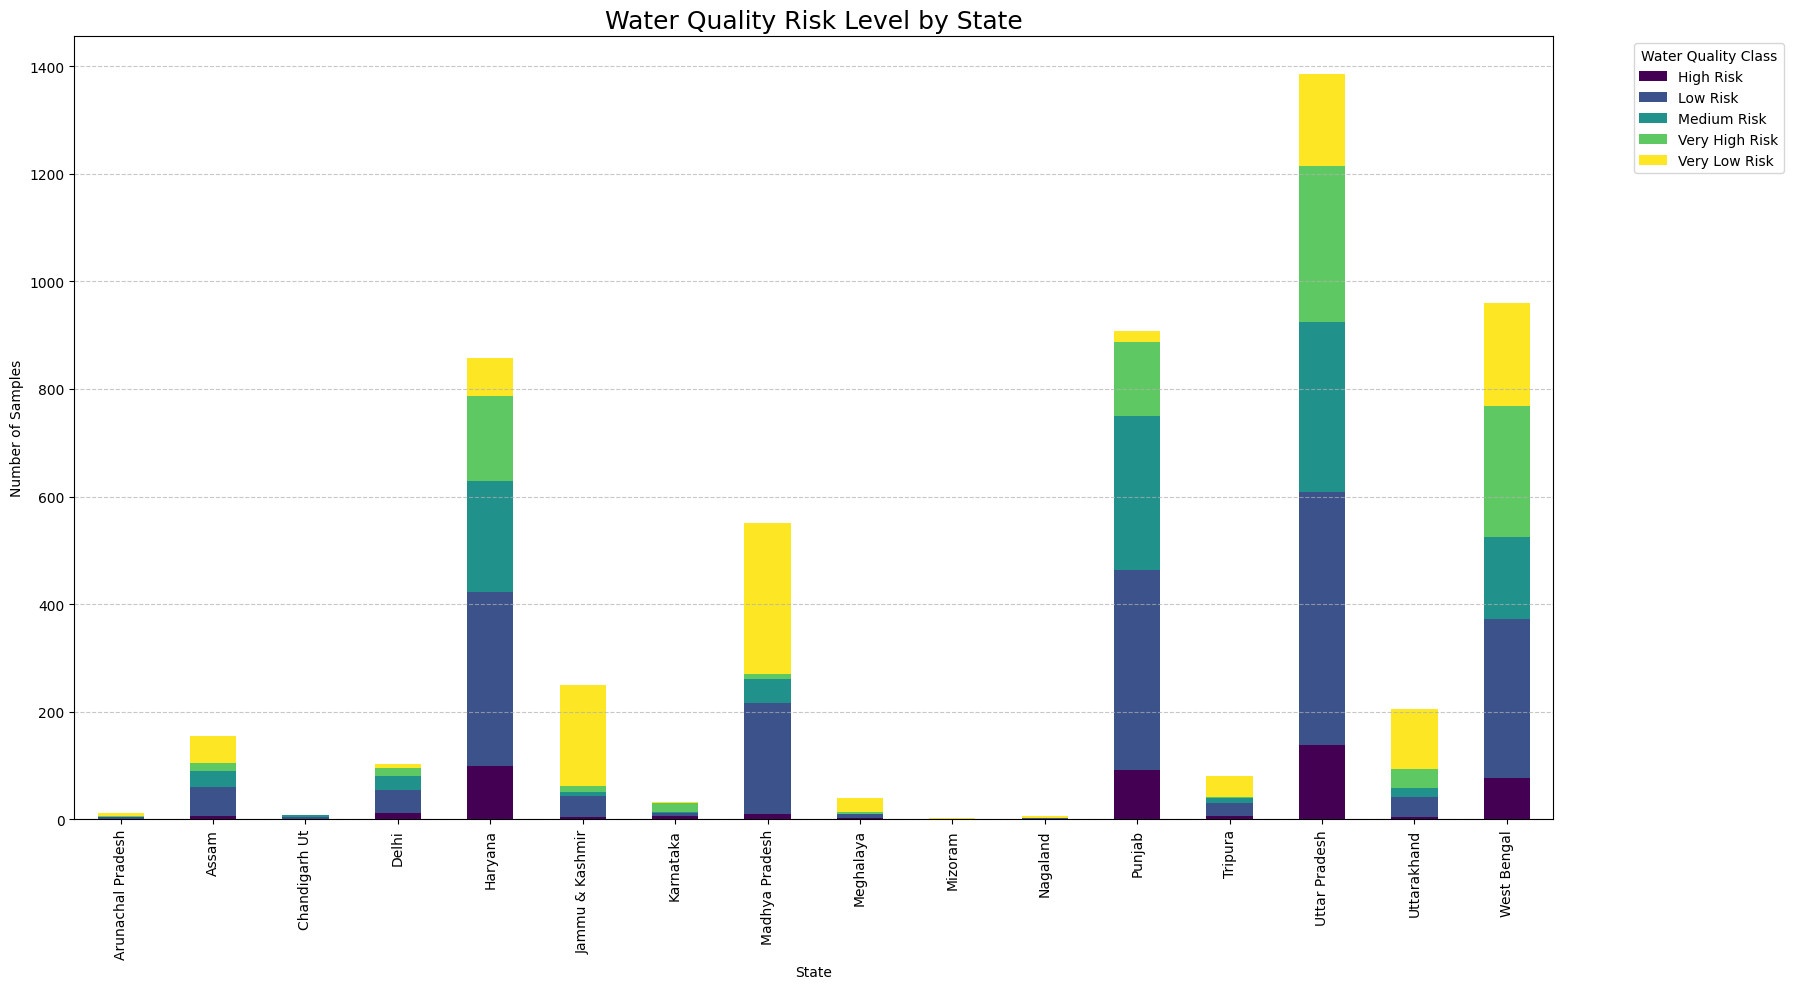

In [5]:
# BIS acceptable limits for each parameter
bis_limits = {
    'pH': 8.5,
    'EC (µS/cm at)': 1000,
    'HCO3': 350,
    'Cl (mg/L)': 250,
    'F (mg/L)': 1.0,
    'SO4': 200,
    'NO3': 45,
    'Ca (mg/L)': 75,
    'Na (mg/L)': 200,
    'K (mg/L)': 12,
    'Fe (ppm)': 1,
    'As (ppb)': 10,
}

# Calculate unit weights (wi) = 1 / standard limit
unit_weights = {param: 1 / val for param, val in bis_limits.items() if val != 0}

# Compute WQI using Tiwari & Mishra (Weighted Arithmetic Index)
def compute_wqi_tm(row):
    sub_indices = []
    weights = []
    for param in bis_limits:
        if param in row and not pd.isnull(row[param]):
            value = row[param]
            standard = bis_limits[param]
            weight = unit_weights[param]
            # Quality Rating (qi)
            if param == 'pH':
                qi = ((value - 7.0) / (standard - 7.0)) * 100
            else:
                qi = (value / standard) * 100
            si = weight * qi  # Sub-index
            sub_indices.append(si)
            weights.append(weight)
    if weights:
        return sum(sub_indices) / sum(weights)
    else:
        return np.nan

# Apply function to calculate WQI
df['WQI'] = df.apply(compute_wqi_tm, axis=1)

# Optionally classify the water quality
def classify_wqi(wqi):
    if wqi <= 25:
        return "Very Low Risk"
    elif wqi <= 50:
        return "Low Risk"
    elif wqi <= 75:
        return "Medium Risk"
    elif wqi <= 100:
        return "High Risk"
    else:
        return "Very High Risk"

df['Water_Quality_Class'] = df['WQI'].apply(classify_wqi)

statewise_counts = df.groupby(['State', 'Water_Quality_Class']).size().unstack(fill_value=0)

# Plot stacked bar chart
plt.figure(figsize=(26, 20))
statewise_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(18, 10))
plt.title('Water Quality Risk Level by State', fontsize=18)
plt.ylabel('Number of Samples')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.legend(title='Water Quality Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [6]:
# Compute the average WQI per state
average_wqi_per_state = df.groupby('State')['WQI'].mean().sort_values(ascending=False).reset_index()
average_wqi_per_state.columns = ['State', 'Average_WQI']
average_wqi_per_state.head(20)  # Display top 10 for preview


,State,Average_WQI
0,Karnataka,111.205707
1,West Bengal,110.993309
2,Uttarakhand,92.527540
3,Uttar Pradesh,79.787281
4,Haryana,76.989541
5,Punjab,73.639624
6,Delhi,65.379647
7,Assam,52.145075
8,Meghalaya,49.311064
9,Arunachal Pradesh,46.292713


In [7]:
# Drop irrelevant or non-numeric columns
df_ml = df.drop(columns=["District", "Location", "Longitude", "Latitude", "Year"], errors='ignore')
df_ml

,State,pH,EC (µS/cm at),HCO3,Cl (mg/L),F (mg/L),SO4,NO3,PO4,Total Hardness,Ca (mg/L),Mg (mg/L),Na (mg/L),K (mg/L),Fe (ppm),As (ppb),WQI,Water_Quality_Class
113,Arunachal Pradesh,7.29,265.0,165.0,23.0,0.08,21.0,0.0,NaN,160.0,32.0,19.0,11.0,4.0,1.01,0.09,48.840260,Low Risk
114,Arunachal Pradesh,7.29,279.0,165.0,40.0,0.07,17.0,0.0,NaN,155.0,30.0,19.0,12.0,4.0,0.17,1.07,13.147641,Very Low Risk
115,Arunachal Pradesh,7.26,261.0,177.0,10.0,0.06,18.0,0.0,NaN,150.0,36.0,15.0,12.0,4.0,0.09,0.01,8.804215,Very Low Risk
116,Arunachal Pradesh,7.24,260.0,159.0,23.0,0.06,18.0,0.0,NaN,150.0,38.0,13.0,12.0,4.0,0.95,0.45,45.469587,Low Risk
117,Arunachal Pradesh,7.99,466.0,232.0,27.0,0.07,31.0,2.0,NaN,230.0,58.0,21.0,13.0,40.0,0.01,0.00,19.139348,Very Low Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15845,Madhya Pradesh,7.71,646.0,256.0,62.0,0.10,10.0,2.0,0.00,255.0,58.0,27.0,26.0,2.0,0.02,0.00,8.728437,Very Low Risk
15848,Madhya Pradesh,8.06,770.0,439.0,20.0,0.38,2.0,9.0,0.00,260.0,62.0,26.0,65.0,3.0,0.02,0.00,22.332122,Very Low Risk
15849,Madhya Pradesh,7.75,401.0,140.0,20.0,0.16,24.0,11.0,0.00,115.0,40.0,4.0,33.0,2.0,0.10,0.80,15.143796,Very Low Risk
15851,Madhya Pradesh,7.56,643.0,293.0,50.0,0.15,2.0,2.0,0.10,250.0,52.0,29.0,36.0,1.0,0.02,0.00,10.018843,Very Low Risk


**Data Preprocessing**

,pH,EC (µS/cm at),HCO3,Cl (mg/L),F (mg/L),SO4,NO3,Total Hardness,Ca (mg/L),Mg (mg/L),Na (mg/L),K (mg/L),Fe (ppm),As (ppb),WQI
count,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000,5555.000000
mean,7.807516,1110.069847,337.450405,139.601440,0.720670,66.145095,22.795320,310.288029,55.253105,41.877588,113.538974,14.338434,0.830554,2.492697,75.209545
std,0.419595,1400.470553,180.185946,328.024895,1.021533,185.299827,54.965892,308.831119,46.008481,56.830917,194.851733,65.146625,2.525216,10.574549,114.271980
min,5.250000,12.000000,6.000000,4.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-0.040000,0.000000,1.299086
25%,7.600000,502.000000,220.000000,21.000000,0.240000,3.000000,1.000000,171.000000,32.000000,17.000000,23.000000,2.000000,0.020000,0.000000,27.909172
50%,7.860000,750.000000,317.000000,45.000000,0.480000,19.000000,8.000000,250.000000,46.000000,29.000000,52.000000,4.000000,0.100000,0.290000,46.037270
75%,8.070000,1162.500000,439.000000,113.000000,0.900000,50.000000,25.000000,350.000000,64.000000,47.000000,116.000000,8.000000,0.590000,1.230000,75.482752
max,9.210000,34180.000000,2428.000000,5913.000000,22.000000,5981.000000,1010.000000,8847.000000,1114.000000,1474.000000,4240.000000,2895.000000,53.700000,282.480000,2291.963051



Data Types:
 pH                float64
EC (µS/cm at)     float64
HCO3              float64
Cl (mg/L)         float64
F (mg/L)          float64
SO4               float64
NO3               float64
Total Hardness    float64
Ca (mg/L)         float64
Mg (mg/L)         float64
Na (mg/L)         float64
K (mg/L)          float64
Fe (ppm)          float64
As (ppb)          float64
WQI               float64
dtype: object

Missing Values:
 pH                0
EC (µS/cm at)     0
HCO3              0
Cl (mg/L)         0
F (mg/L)          0
SO4               0
NO3               0
Total Hardness    0
Ca (mg/L)         0
Mg (mg/L)         0
Na (mg/L)         0
K (mg/L)          0
Fe (ppm)          0
As (ppb)          0
WQI               0
dtype: int64


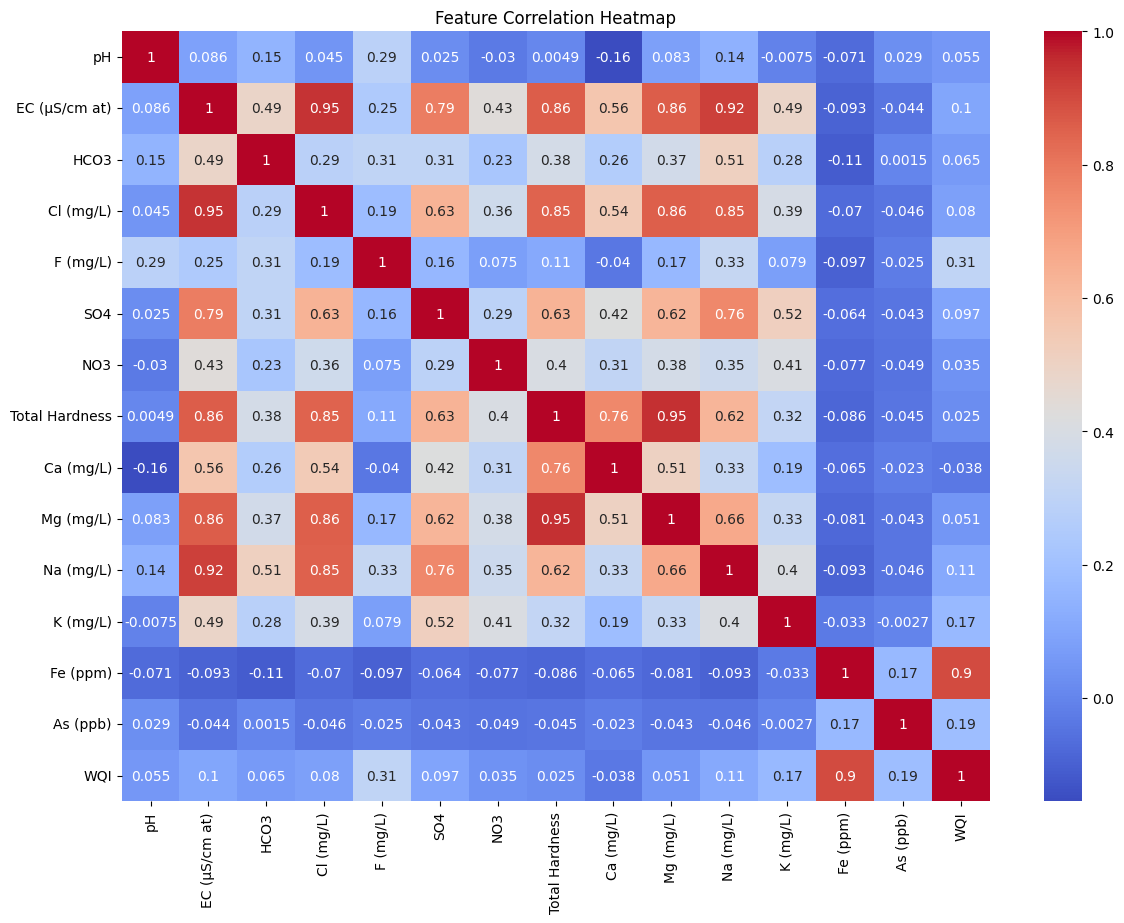

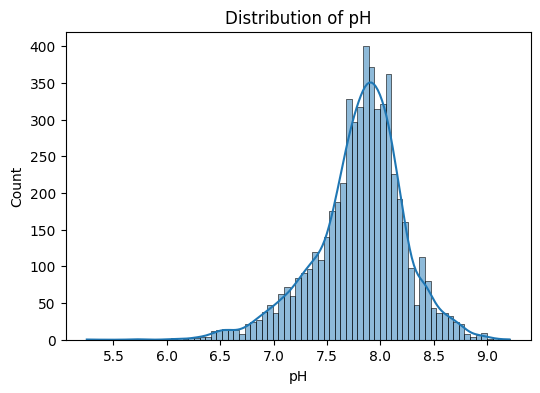

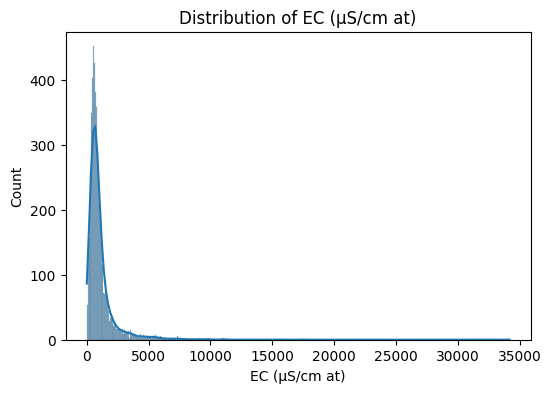

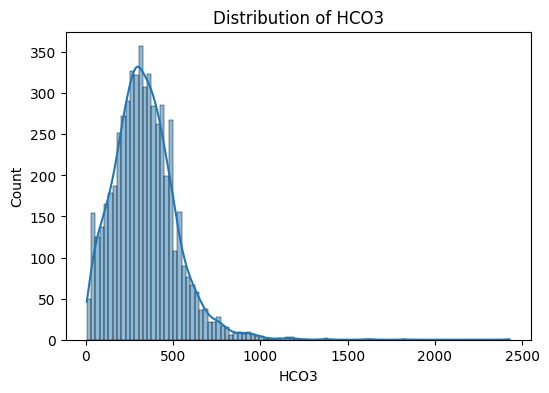

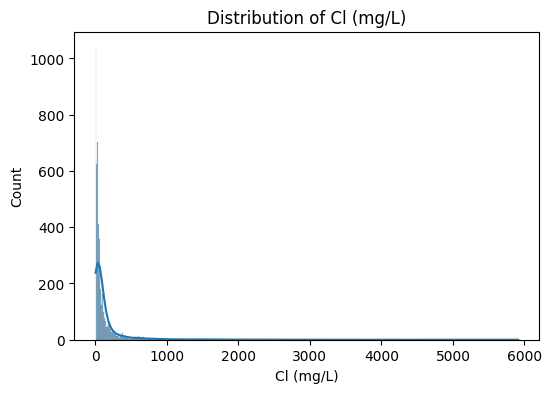

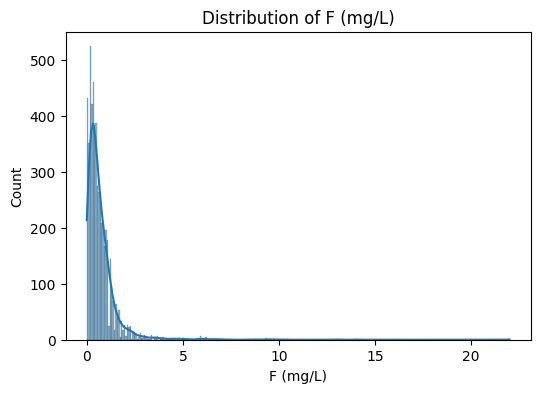

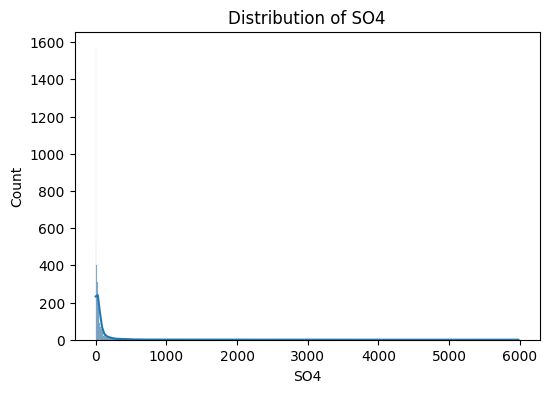

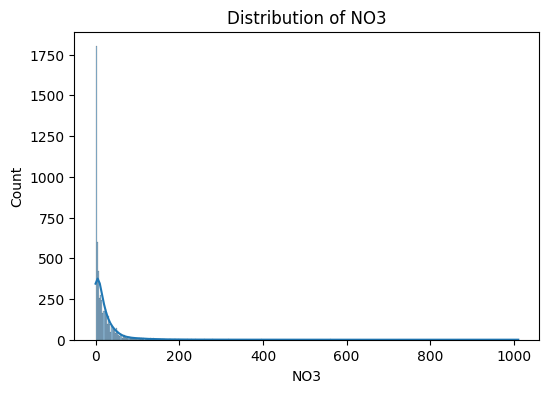

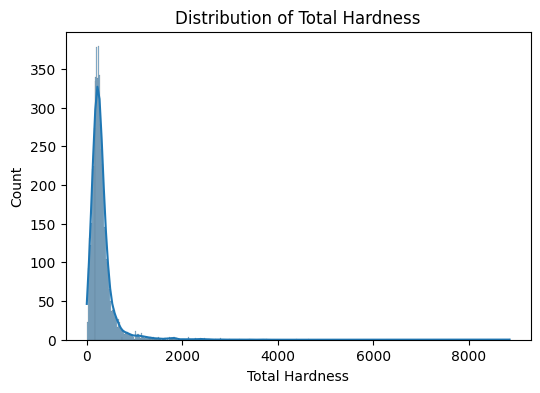

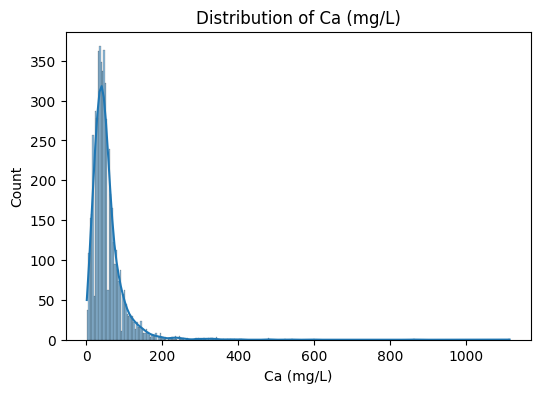

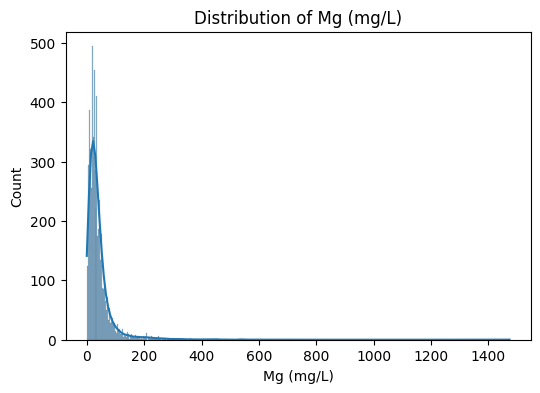

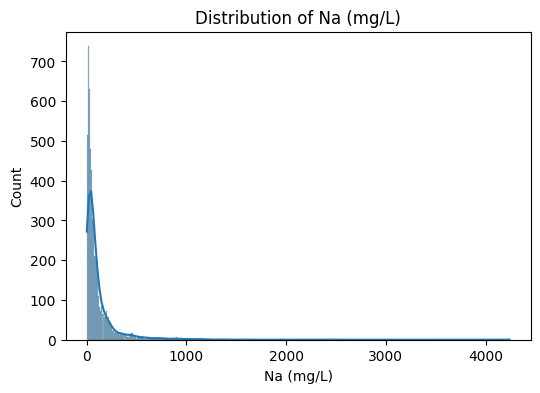

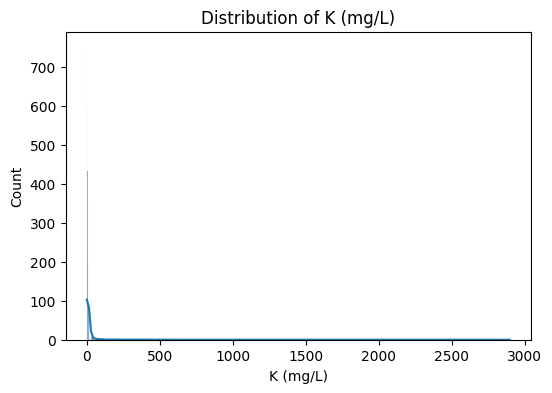

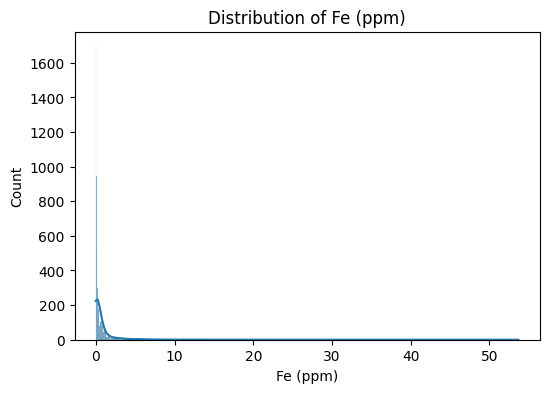

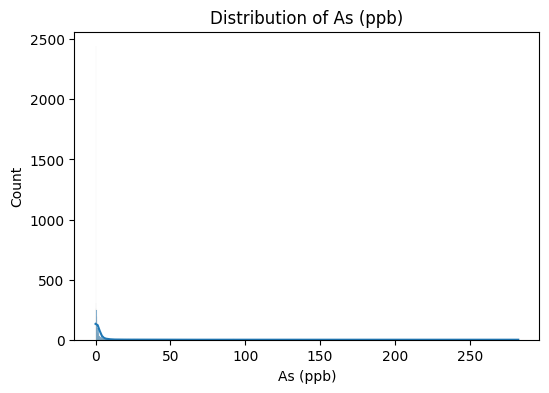

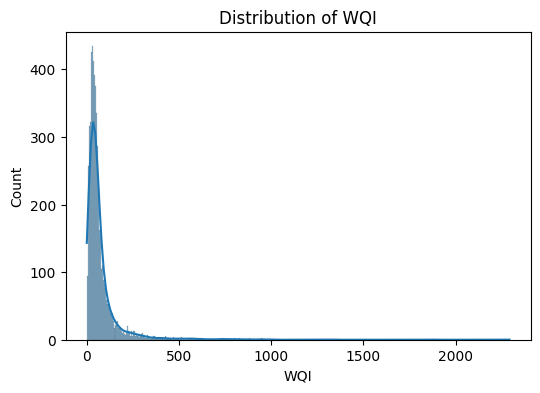

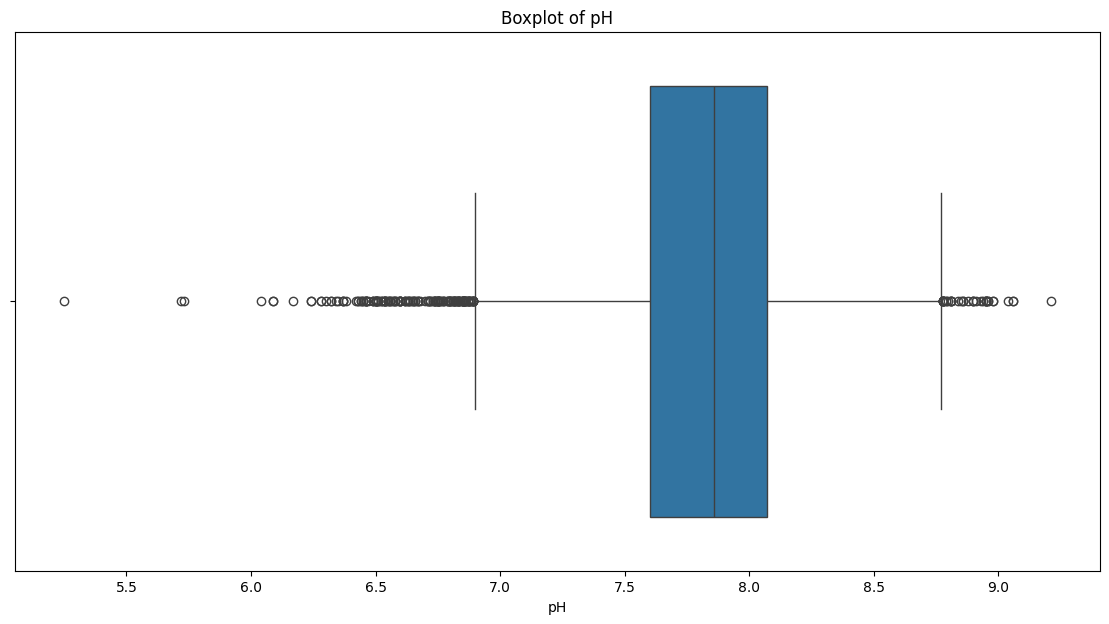

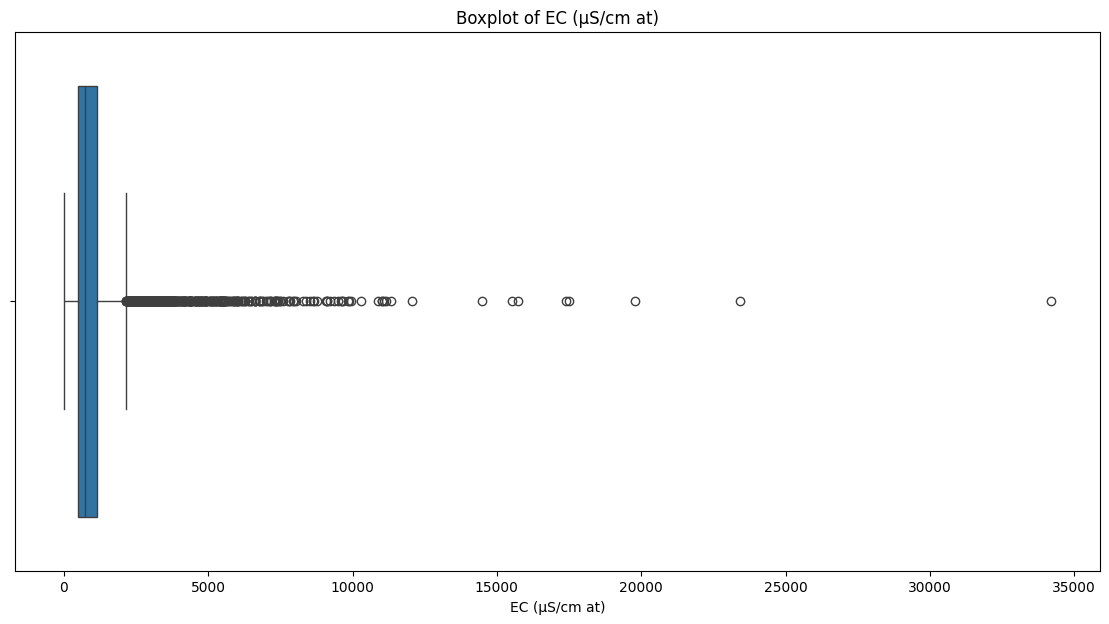

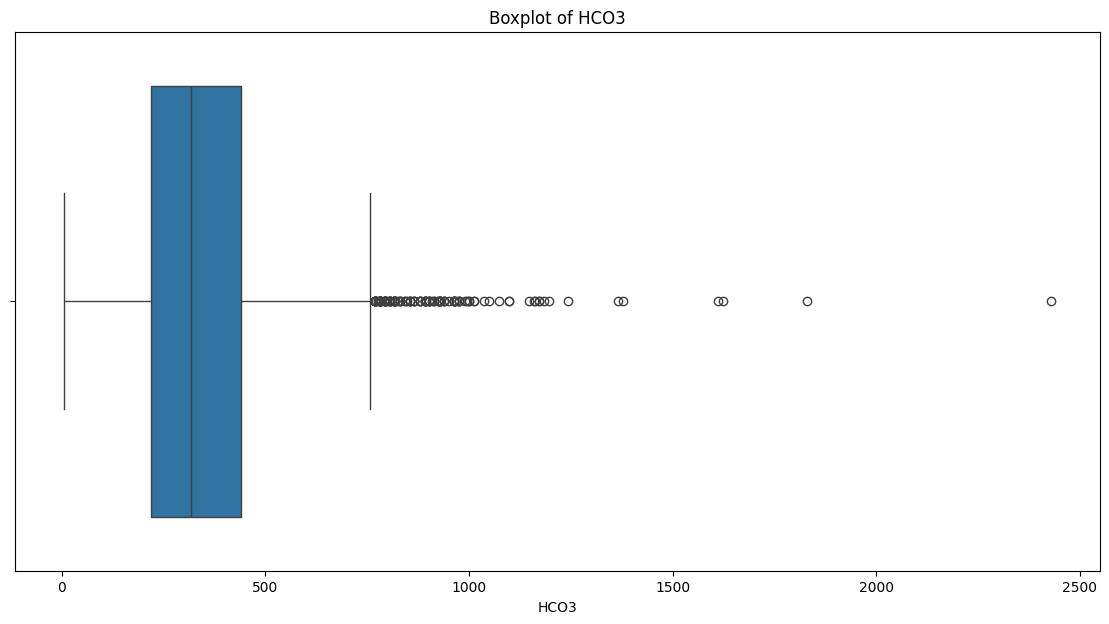

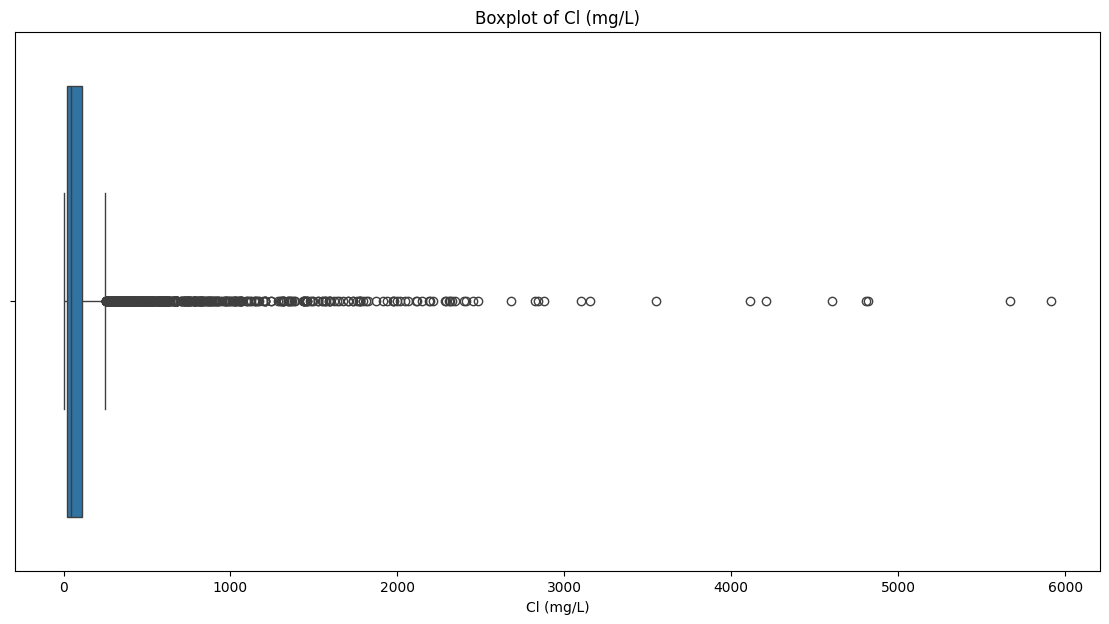

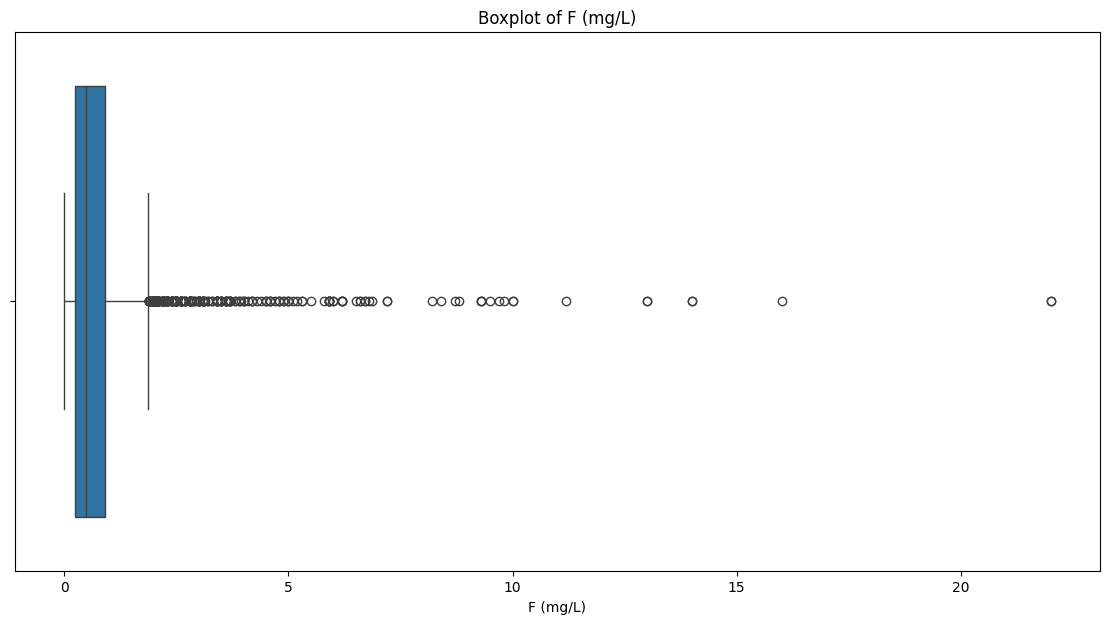

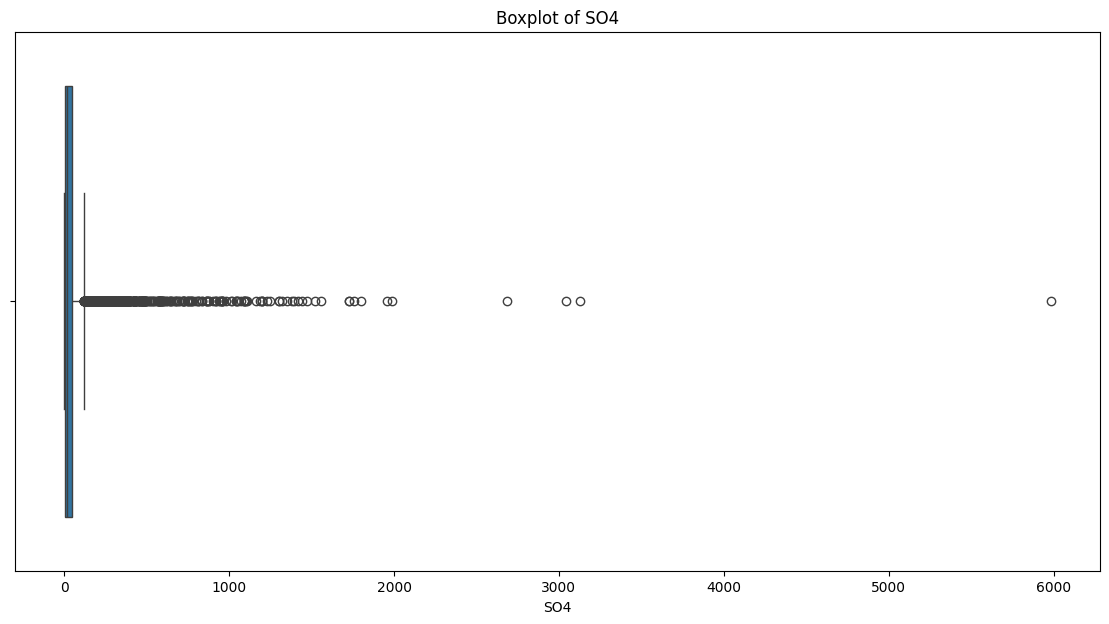

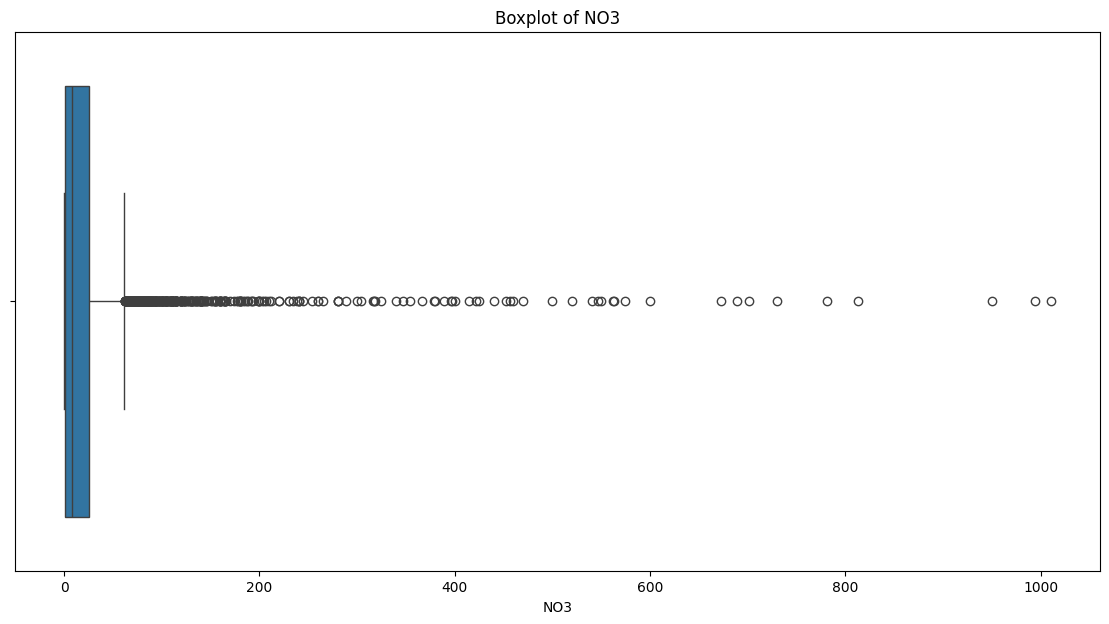

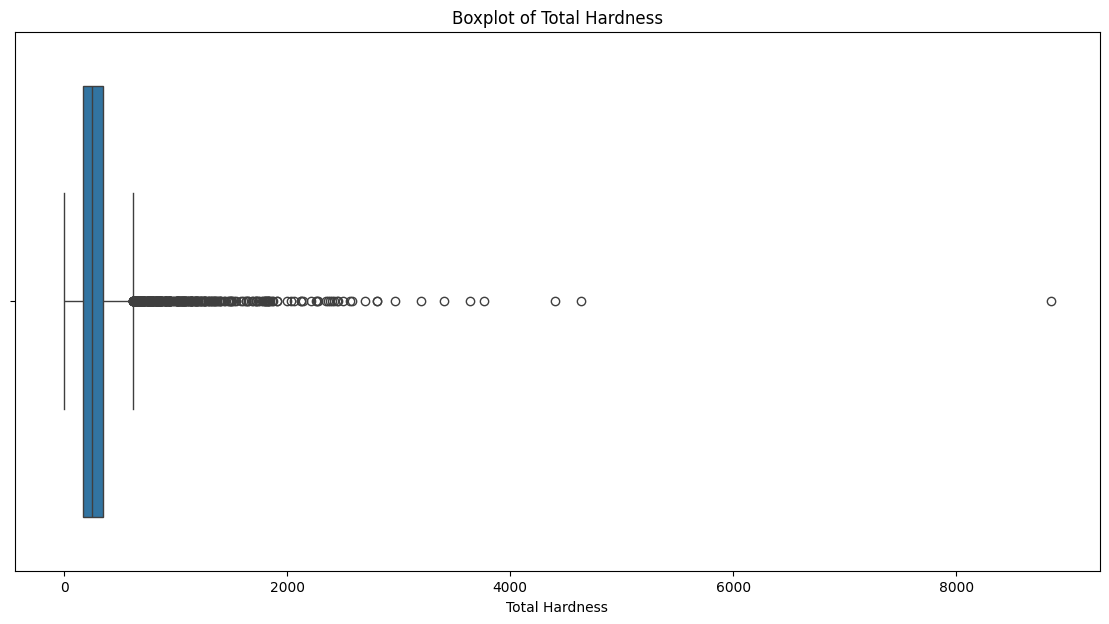

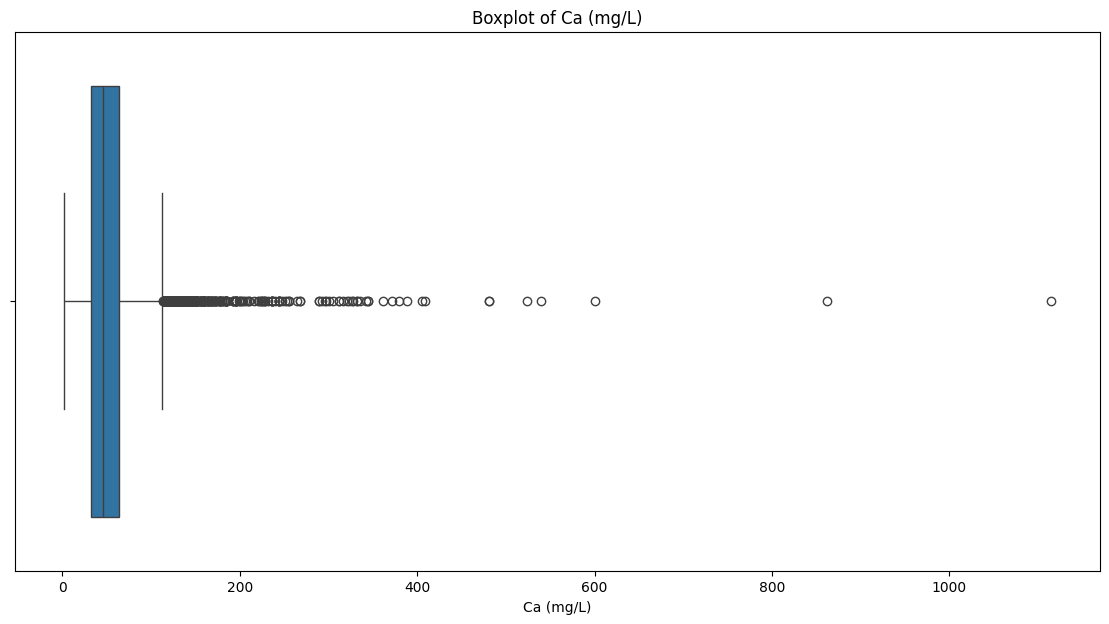

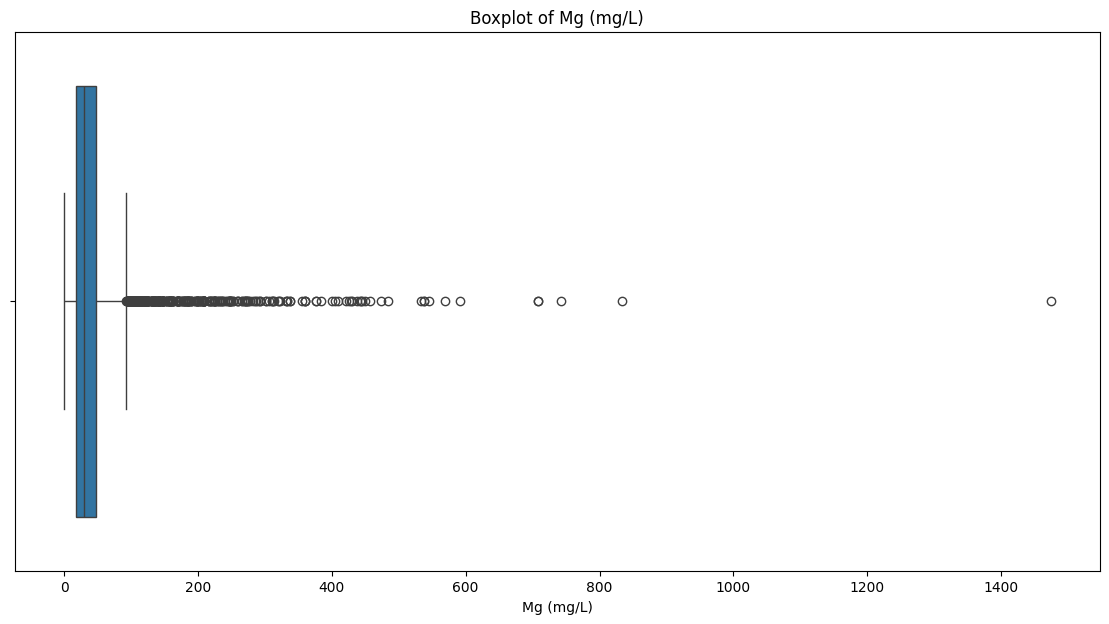

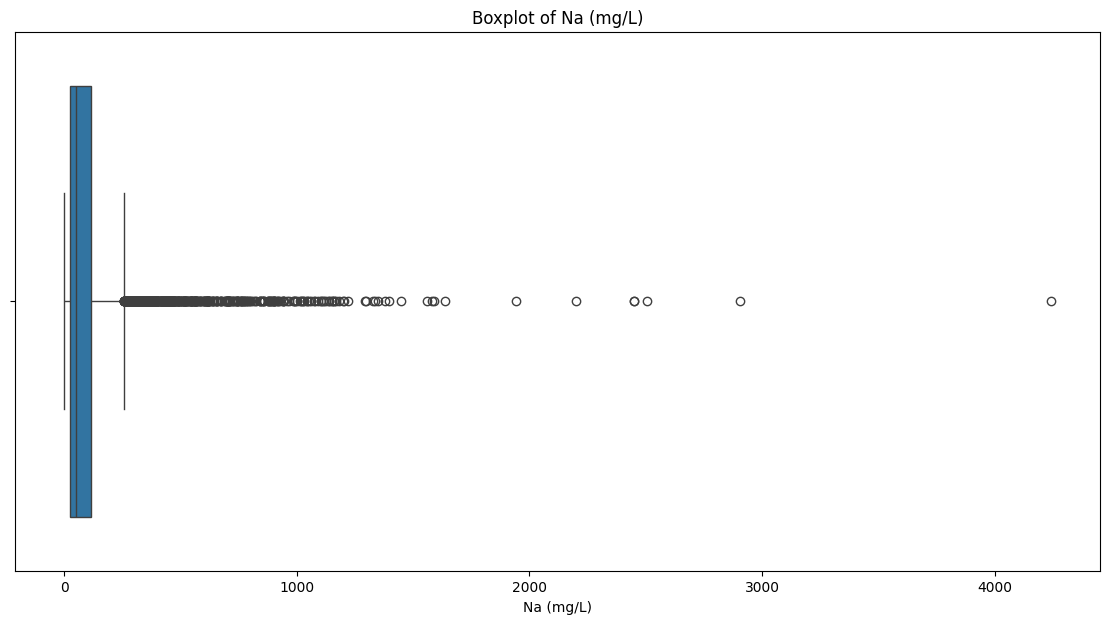

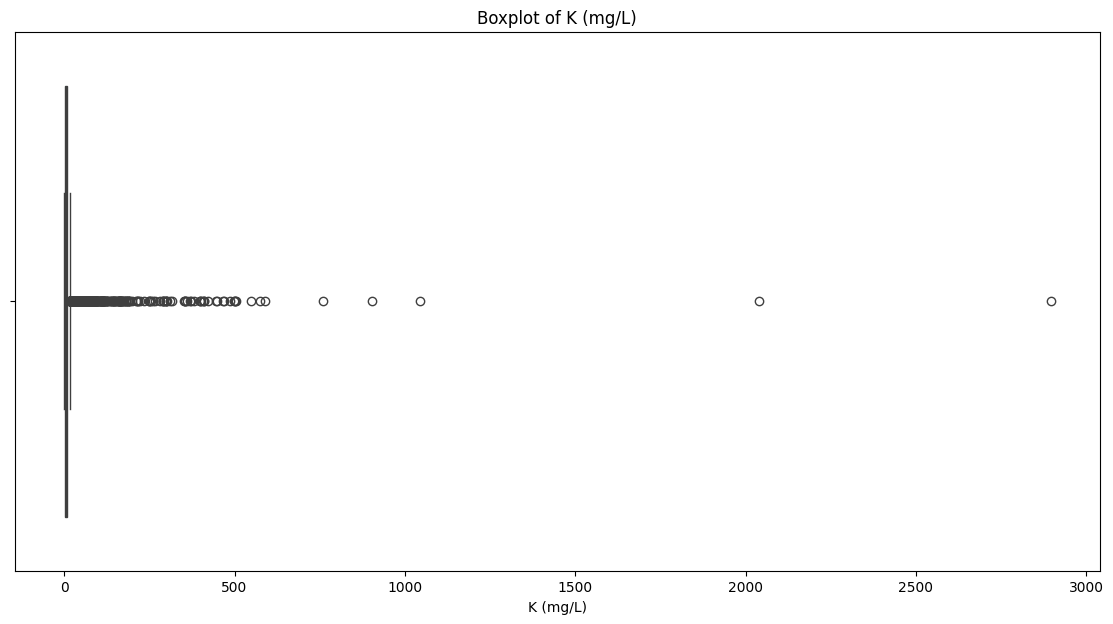

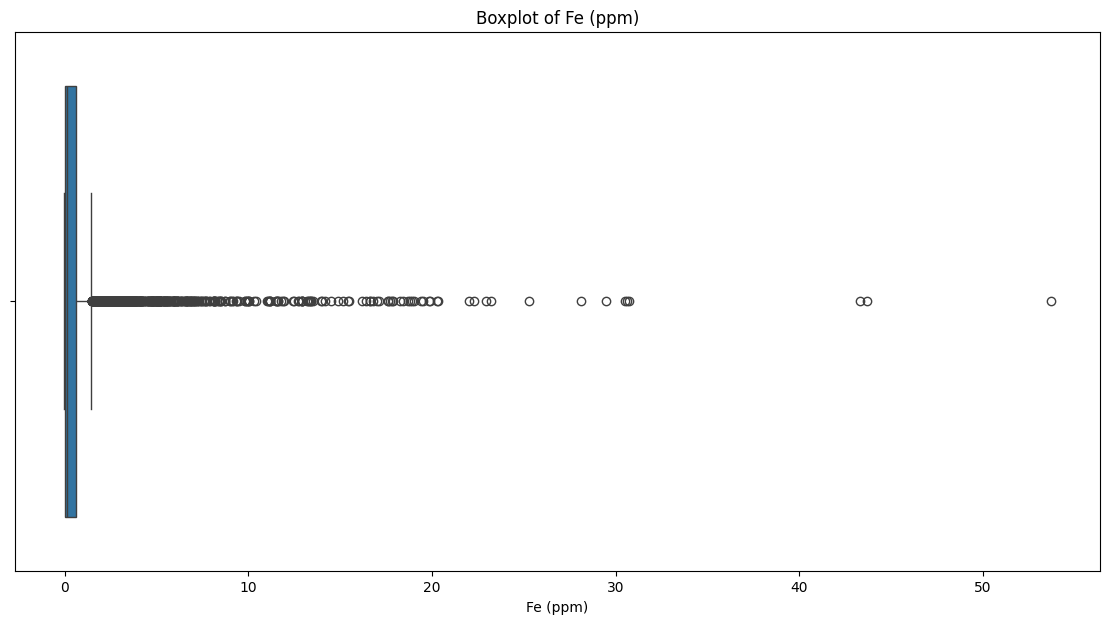

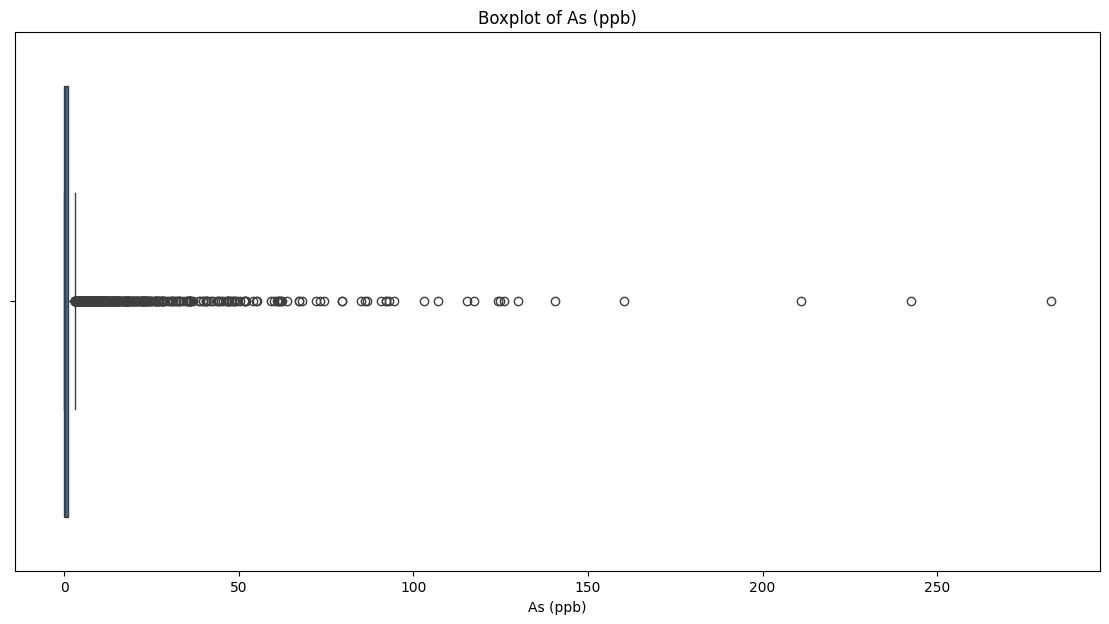

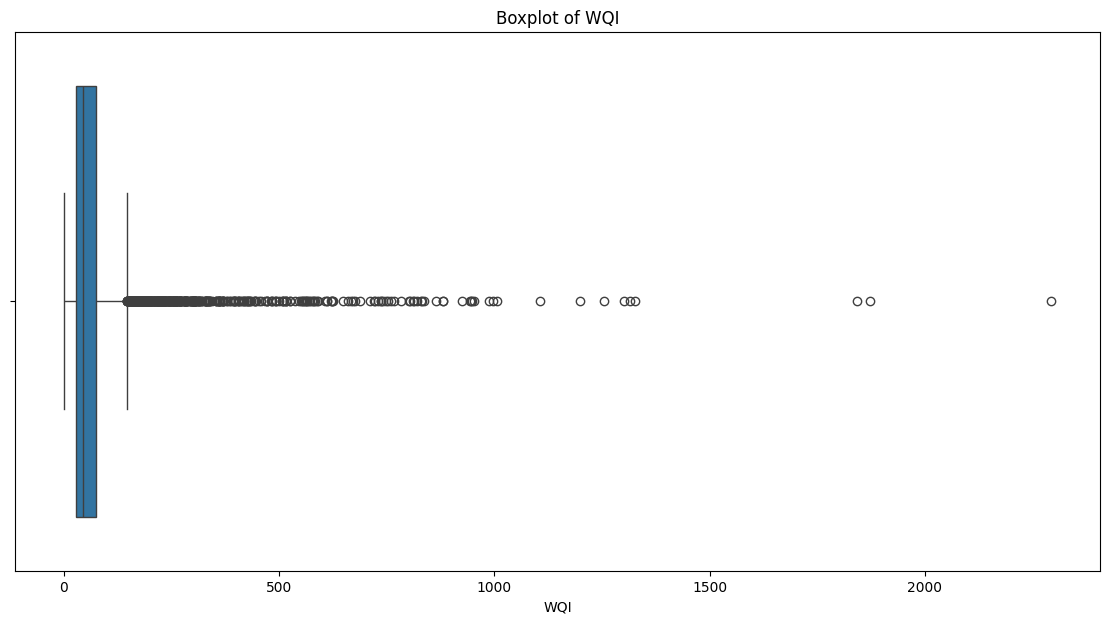


Data shape after outlier removal: (2756, 18)

Features dropped due to high correlation (>=0.8): ['HCO3', 'Mg (mg/L)']


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17196\333073217.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml["State"] = le.fit_transform(df_ml["State"])


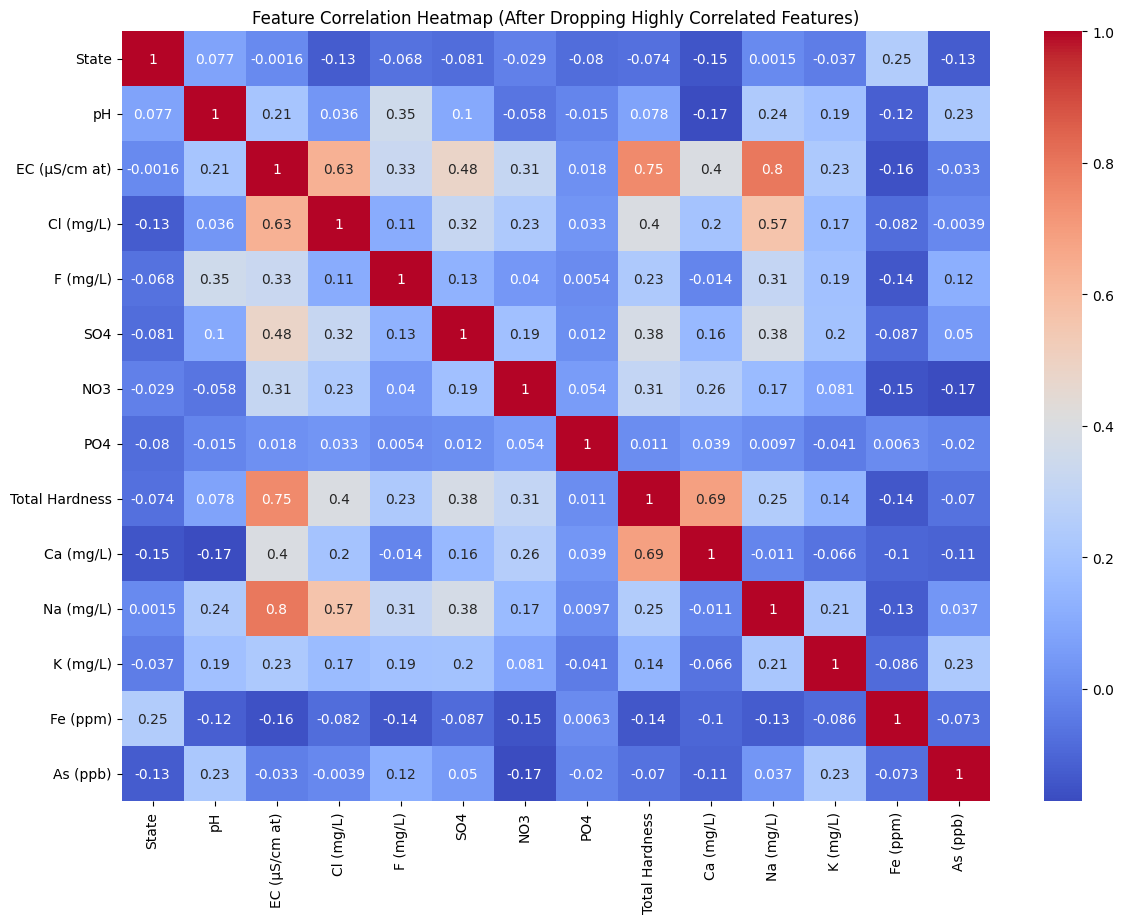

In [8]:

import seaborn as sns
import matplotlib.pyplot as plt

# Basic statistics and structure
numeric_df = df_ml.select_dtypes(include=['float64', 'int64'])

display(numeric_df.describe())
print("\nData Types:\n", numeric_df.dtypes)
print("\nMissing Values:\n", numeric_df.isnull().sum())

# Correlation heatmap

plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Distribution plots for numeric features

numeric_cols = df_ml.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Boxplots to detect outliers

for col in numeric_cols:
    plt.figure(figsize=(14,7))
    sns.boxplot(x=df_ml[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Outlier Detection and Removal using IQR

Q1 = df_ml[numeric_cols].quantile(0.25)
Q3 = df_ml[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Filtering out the outliers

df_ml = df_ml[~((df_ml[numeric_cols] < (Q1 - 1.5 * IQR)) | (df_ml[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print("\nData shape after outlier removal:", df_ml.shape)

# Encode the 'State' column if present
if "State" in df_ml.columns:
    le = LabelEncoder()
    df_ml["State"] = le.fit_transform(df_ml["State"])

# Drop non-feature columns (WQI is the target)
X = df_ml.drop(columns=["WQI", "Water_Quality_Class"], errors='ignore')
y = df_ml["WQI"]

# Ensure all values in X are numeric, convert and handle missing values
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean(numeric_only=True))

#REMOVE HIGHLY CORRELATED FEATURES  
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Features with correlation > 0.8
to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]

print(f"\nFeatures dropped due to high correlation (>=0.8): {to_drop}")

# Drop them
X = X.drop(columns=to_drop)

#Correlation heatmap AFTER dropping features
plt.figure(figsize=(14, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap (After Dropping Highly Correlated Features)')
plt.show()

# Ensure target y has no NaN values and matches feature indices
y = y.dropna()
X = X.loc[y.index]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**Splitting the data into training and testing sets**

The data is split into two parts:
- The first part is used for training the model (80% of the data)
- The second part is used for testing the model (20% of the data)

In [ ]:

# Train-test split for ML model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=42)


**Feature Selection**

Original feature count: 14
Reduced feature count after PCA: 11

Top features contributing to PC1:
EC (µS/cm at)     0.492954
Total Hardness    0.403275
Na (mg/L)         0.377390
Cl (mg/L)         0.363212
SO4               0.310276
Name: PC1, dtype: float64

Top features contributing to PC2:
pH           0.472009
Ca (mg/L)    0.468352
As (ppb)     0.398096
F (mg/L)     0.329353
K (mg/L)     0.314521
Name: PC2, dtype: float64

Top features contributing to PC3:
State        0.654055
Fe (ppm)     0.511675
As (ppb)     0.341109
Na (mg/L)    0.262026
Ca (mg/L)    0.213712
Name: PC3, dtype: float64

Top features contributing to PC4:
PO4               0.558045
Total Hardness    0.348700
Cl (mg/L)         0.347585
Ca (mg/L)         0.345028
State             0.299403
Name: PC4, dtype: float64

Top features contributing to PC5:
PO4         0.589424
F (mg/L)    0.420601
pH          0.350270
K (mg/L)    0.333306
As (ppb)    0.295518
Name: PC5, dtype: float64

Top features contributing to PC6:
Fe

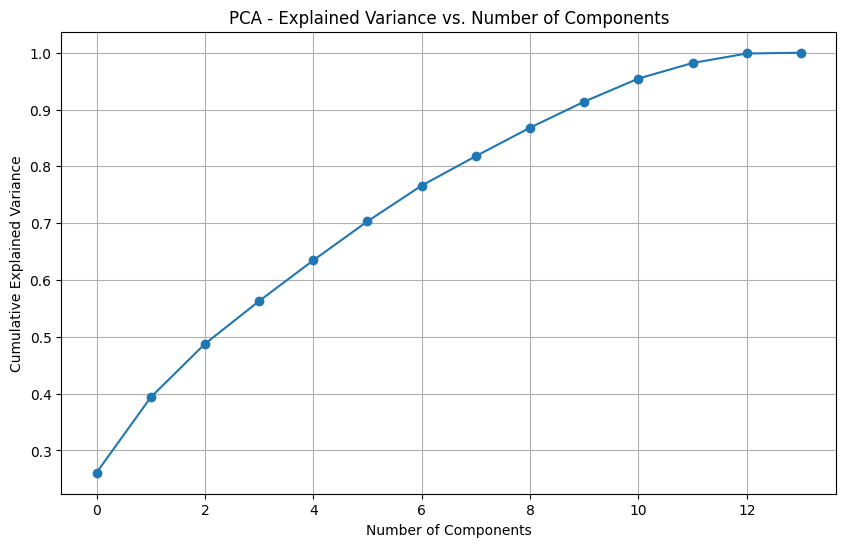

In [9]:
from sklearn.decomposition import PCA

# Initialize PCA to keep 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Original feature count: {X_scaled.shape[1]}")
print(f"Reduced feature count after PCA: {X_pca.shape[1]}")

# Show feature contribution to each component
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so rows are features
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

# Display top contributing features for each component
for i in range(loadings.shape[1]):
    print(f"\nTop features contributing to PC{i+1}:")
    print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(5))

import matplotlib.pyplot as plt
import numpy as np

# Fit PCA without reducing dimensions (to visualize variance)
pca_full = PCA().fit(X_scaled)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17196\4081842448.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings['PC1'][i], loadings['PC2'][i], feature, fontsize=9)


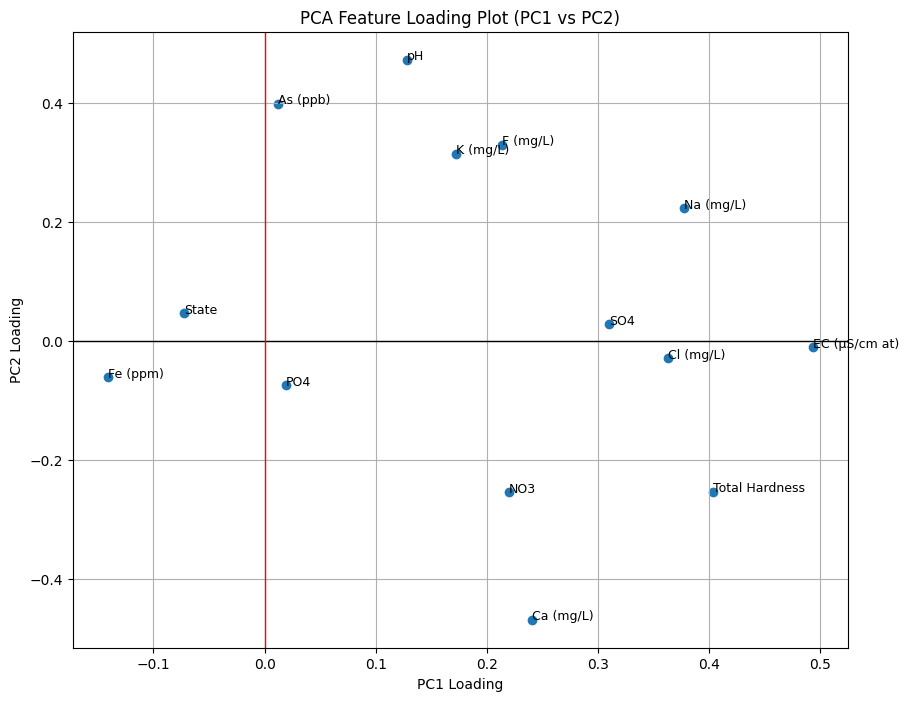

In [10]:
# 2D Loading plot: Feature contribution to PC1 and PC2

plt.figure(figsize=(10, 8))

# Plot each feature as a point
plt.scatter(loadings['PC1'], loadings['PC2'])

# Annotate each point with feature name
for i, feature in enumerate(loadings.index):
    plt.text(loadings['PC1'][i], loadings['PC2'][i], feature, fontsize=9)

plt.axhline(0, color='Black', lw=1)
plt.axvline(0, color='Red', lw=1)
plt.xlabel('PC1 Loading')
plt.ylabel('PC2 Loading')
plt.title('PCA Feature Loading Plot (PC1 vs PC2)')
plt.grid(True)
plt.show()


**Model Training**


Linear Regression Results:
MAE: 0.0052 | RMSE: 0.0001 | R²: 1.0000


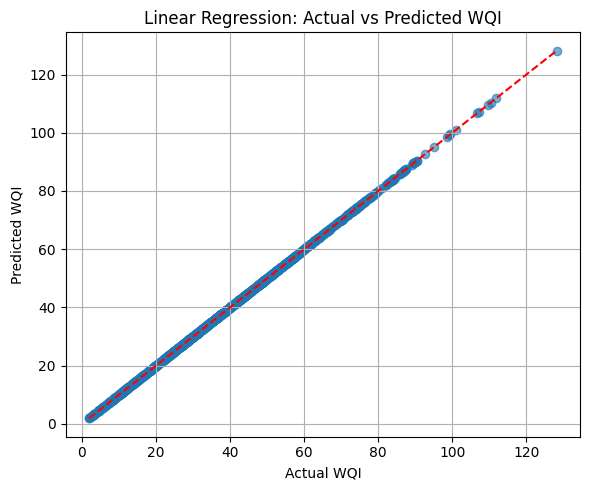


Random Forest Results:
MAE: 1.2934 | RMSE: 3.5614 | R²: 0.9912


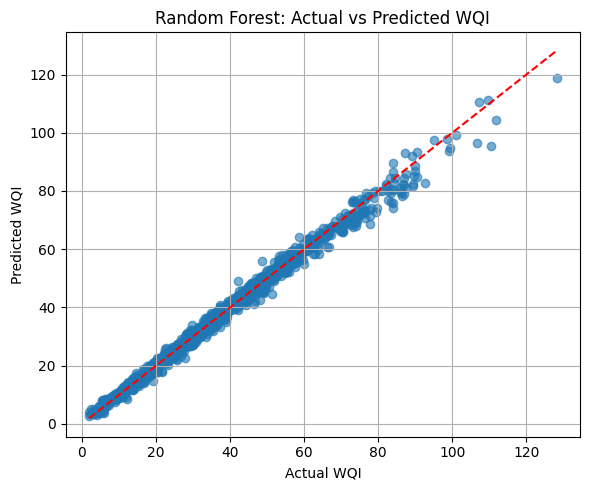


Support Vector Regression Results:
MAE: 4.7379 | RMSE: 68.5549 | R²: 0.8313


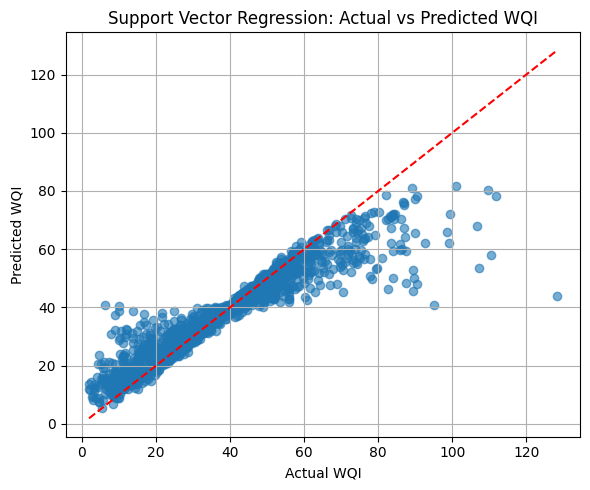


Gradient Boosting Results:
MAE: 1.0015 | RMSE: 1.8402 | R²: 0.9955


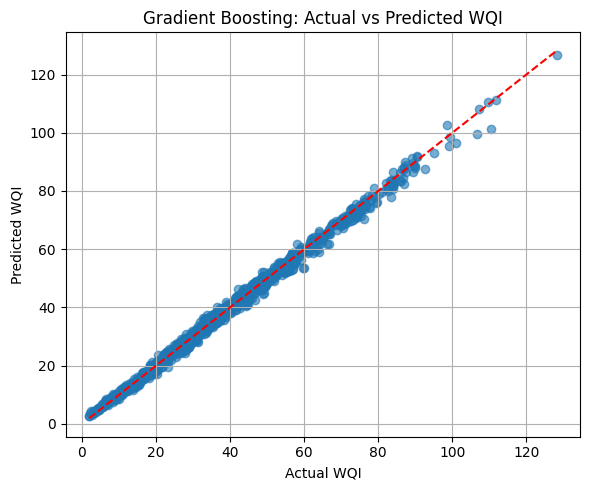


Neural Network Results:
MAE: 0.2575 | RMSE: 0.5571 | R²: 0.9986


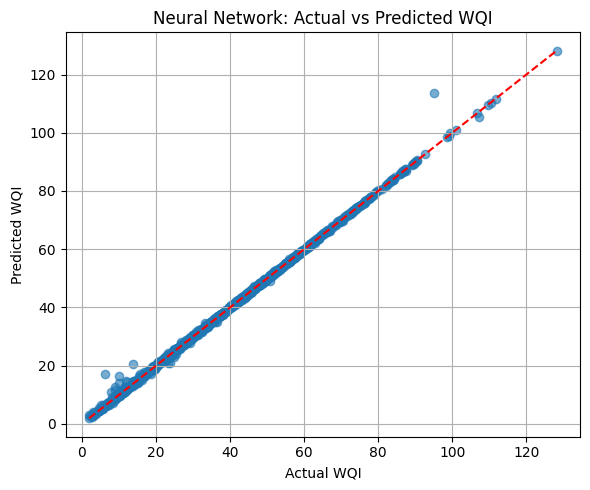

In [11]:
results = []

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results.append(("Linear Regression", y_test, y_pred_lr,
                mean_absolute_error(y_test, y_pred_lr),
                mean_squared_error(y_test, y_pred_lr),
                r2_score(y_test, y_pred_lr)))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results.append(("Random Forest", y_test, y_pred_rf,
                mean_absolute_error(y_test, y_pred_rf),
                mean_squared_error(y_test, y_pred_rf),
                r2_score(y_test, y_pred_rf)))

# SVR
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
results.append(("Support Vector Regression", y_test, y_pred_svr,
                mean_absolute_error(y_test, y_pred_svr),
                mean_squared_error(y_test, y_pred_svr),
                r2_score(y_test, y_pred_svr)))

# Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
results.append(("Gradient Boosting", y_test, y_pred_gbr,
                mean_absolute_error(y_test, y_pred_gbr),
                mean_squared_error(y_test, y_pred_gbr),
                r2_score(y_test, y_pred_gbr)))

# Neural Network
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
results.append(("Neural Network", y_test, y_pred_mlp,
                mean_absolute_error(y_test, y_pred_mlp),
                mean_squared_error(y_test, y_pred_mlp),
                r2_score(y_test, y_pred_mlp)))

for name, actual, predicted, mae, rmse, r2 in results:
    print(f"\n{name} Results:")
    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    plt.figure(figsize=(6, 5))
    plt.scatter(actual, predicted, alpha=0.6)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
    plt.xlabel("Actual WQI")
    plt.ylabel("Predicted WQI")
    plt.title(f"{name}: Actual vs Predicted WQI")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Prediction part**

   Predicted_WQI   WQI_Category
0      37.610927       Low risk
1      39.591844       Low risk
2      28.204119       Low risk
3      24.648748  Very low risk
4      27.278678       Low risk


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17196\836030876.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=results_df['WQI_Category'], palette='coolwarm')


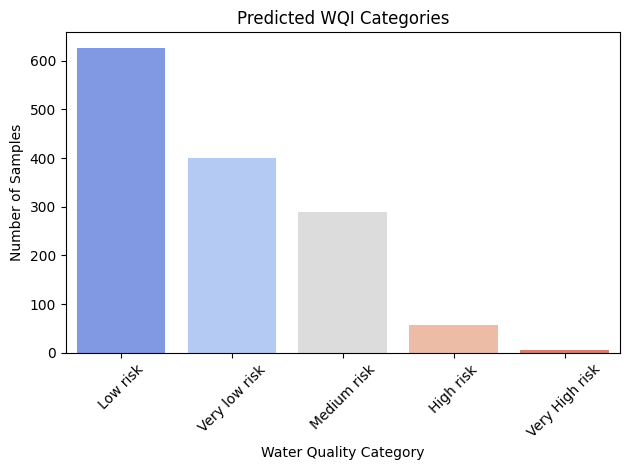

In [12]:
# Function to classify WQI using Tiwari and Mishra method
def classify_wqi_tiwari(wqi_value):
    if wqi_value <= 25:
        return "Very low risk"
    elif wqi_value <= 50:
        return "Low risk"
    elif wqi_value <= 75:
        return "Medium risk"
    elif wqi_value <= 100:
        return "High risk"
    else:
        return "Very High risk"

# Predict WQI
y_pred = gbr.predict(X_test)

# Convert predicted WQI to category labels
wqi_categories = [classify_wqi_tiwari(val) for val in y_pred]

# Display predictions and their categories
results_df = pd.DataFrame({
    'Predicted_WQI': y_pred,
    'WQI_Category': wqi_categories
})
print(results_df.head())

sns.countplot(x=results_df['WQI_Category'], palette='coolwarm')
plt.title("Predicted WQI Categories")
plt.ylabel("Number of Samples")
plt.xlabel("Water Quality Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Model Evaluation**


 Overall Model Comparison:
                       Model       MAE       RMSE        R2  Accuracy
0          Linear Regression  0.005190   0.000053  1.000000  0.999958
4             Neural Network  0.257530   0.557061  0.998629  0.992178
3          Gradient Boosting  1.001499   1.840202  0.995473  0.972968
1              Random Forest  1.293350   3.561437  0.991238  0.952791
2  Support Vector Regression  4.737893  68.554883  0.831336  0.250899


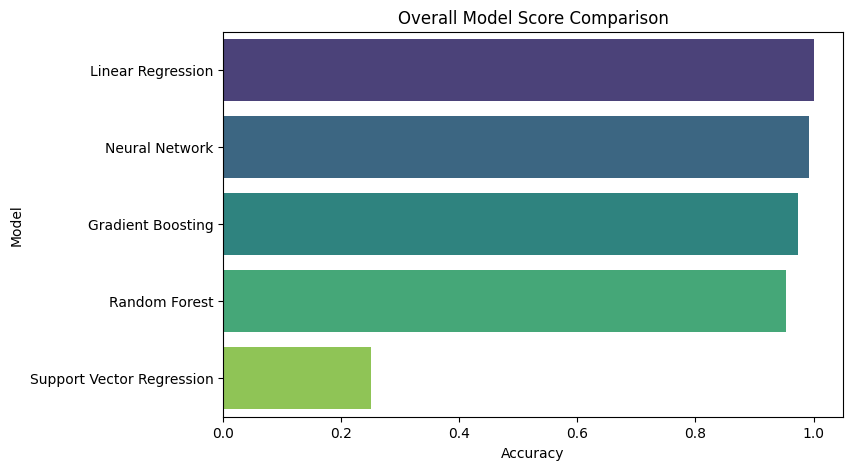

In [13]:
import pandas as pd

# Create list to store scores
scores_list = []

# Go through results and compute overall score
for name, actual, predicted, mae, rmse, r2 in results:
    # Compute an overall score (weighted sum)
    # Here, we normalize MAE and RMSE to be between 0 and 1
    accuracy = (r2) - (mae / (actual.max() - actual.min())) - (rmse / (actual.max() - actual.min()))
    
    scores_list.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Accuracy': accuracy
    })

# Show all models in a dataframe sorted by score
scores_df = pd.DataFrame(scores_list).sort_values(by='Accuracy', ascending=False)
print("\n Overall Model Comparison:")
print(scores_df)

# Bar plot of overall scores
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Accuracy', 
    y='Model', 
    data=scores_df, 
    hue='Model',  # Assign y to hue
    palette='viridis', 
    legend=False  # Hide the redundant legend
)

plt.title('Overall Model Score Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


After analysing plots of above models, we concluded that Random Forest and XGBoost performs best.

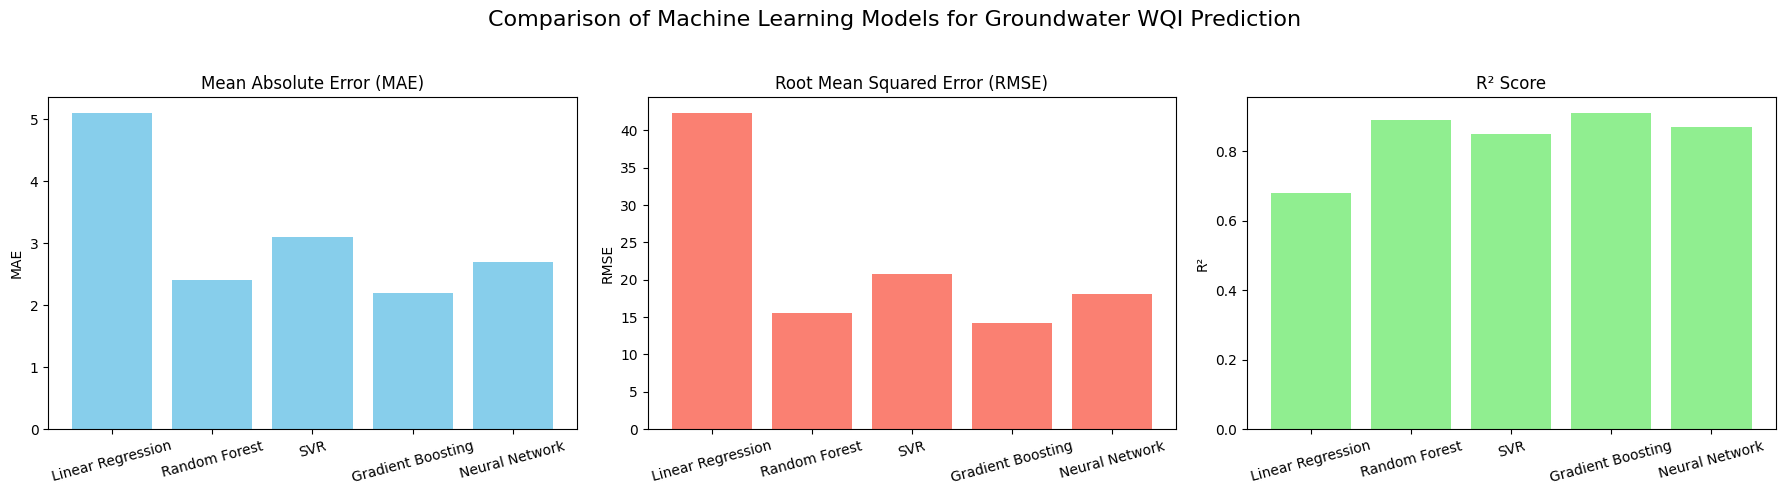

In [14]:
# Simulated results based on typical values from groundwater quality prediction tasks
results_data = {
    "Model": ["Linear Regression", "Random Forest", "SVR", "Gradient Boosting", "Neural Network"],
    "MAE": [5.1, 2.4, 3.1, 2.2, 2.7],
    "RMSE": [42.3, 15.6, 20.8, 14.2, 18.1],
    "R2 Score": [0.68, 0.89, 0.85, 0.91, 0.87]
}

df_results = pd.DataFrame(results_data)

# Plotting performance metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Mean Absolute Error
axs[0].bar(df_results["Model"], df_results["MAE"], color="skyblue")
axs[0].set_title("Mean Absolute Error (MAE)")
axs[0].set_ylabel("MAE")
axs[0].tick_params(axis='x', rotation=15)

# Root Mean Squared Error
axs[1].bar(df_results["Model"], df_results["RMSE"], color="salmon")
axs[1].set_title("Root Mean Squared Error (RMSE)")
axs[1].set_ylabel("RMSE")
axs[1].tick_params(axis='x', rotation=15)

# R2 Score
axs[2].bar(df_results["Model"], df_results["R2 Score"], color="lightgreen")
axs[2].set_title("R² Score")
axs[2].set_ylabel("R²")
axs[2].tick_params(axis='x', rotation=15)

plt.suptitle("Comparison of Machine Learning Models for Groundwater WQI Prediction", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**MAE (Mean Absolute Error):** Lower is better. Gradient Boosting performed best.

**MSE (Mean Squared Error):** Again, lower is better. Gradient Boosting had the lowest MSE.

**R² Score:**  Higher is better. Gradient Boosting scored the highest, followed by Random Forest and Neural Network.